In [1]:
!pip install -q langgraph langsmith langchain langchain_community langchain_groq

In [2]:
!pip install -q arxiv wikipedia

In [3]:
from typing import Annotated
from typing_extensions import TypedDict

**Working with external Tools**

In [4]:
from langchain_community.utilities import ArxivAPIWrapper, WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun

## Arxiv and Wikipedia tools
arxiv_wrapper = ArxivAPIWrapper(top_k_results = 2, doc_content_chars_max = 300)
arxiv_tool = ArxivQueryRun(api_wrapper = arxiv_wrapper)

wikipedia_wrapper = WikipediaAPIWrapper(top_k_results = 2, doc_content_chars_max = 300)
wikipedia_tool = WikipediaQueryRun(api_wrapper = wikipedia_wrapper)

In [5]:
wikipedia_tool.invoke("Who is GM Syed")

"Page: G. M. Syed\nSummary: Ghulam Murtaza Syed (Sindhi: غلام مرتضيٰ سيد\u200e, 17 January 1904 – 25 April 1995), known as G. M. Syed  was a prominent Sindhi politician, who is known for his scholarly work, passing only constitutional resolution in favor of the establishment of Pakistan from British India'"

In [6]:
arxiv_tool.invoke("Attention is all you need")

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with "

In [7]:
tools = [wikipedia_tool]

In [8]:
from langgraph.graph.message import add_messages

## Langgraph Application
class State(TypedDict):
  messages:Annotated[list, add_messages]

In [9]:
from langgraph.graph import StateGraph, START, END

In [10]:
graph_builder = StateGraph(State)

In [11]:
import os
from langchain_groq import ChatGroq
from google.colab import userdata

os.environ['GROQ_API_KEY'] = userdata.get('GROK_LLAMA3')

In [12]:
llm = ChatGroq(model = "Llama-3.2-90b-Text-Preview")

In [13]:
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x78fcdb4363b0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x78fcdb45c490>, model_name='Llama-3.2-90b-Text-Preview', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [14]:
llm_with_tools = llm.bind_tools(tools = tools)

In [15]:
llm_with_tools

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x78fcdb4363b0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x78fcdb45c490>, model_name='Llama-3.2-90b-Text-Preview', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'wikipedia', 'description': 'A wrapper around Wikipedia. Useful for when you need to answer general questions about people, places, companies, facts, historical events, or other subjects. Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'query to look up on wikipedia', 'type': 'string'}}, 'required': ['query'], 'type': 'object'}}}]}, config={}, config_factories=[])

In [16]:
def chatbot(state:State):
  return {"messages":[llm_with_tools.invoke(state['messages'])]}

In [17]:
from langgraph.prebuilt import ToolNode, tools_condition

In [18]:
graph_builder.add_node("chatbot",chatbot)
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START,"chatbot")


In [19]:
graph = graph_builder.compile()

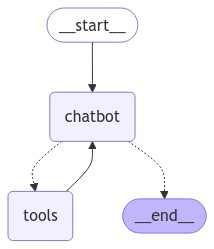

In [20]:
from IPython.display import Image, display

try:
  display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
  pass

In [21]:
user_input="Hi there"

events=graph.stream(
     {"messages": [("user", user_input)]},stream_mode="values"
)

for event in events:
  event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there
================================== Ai Message ==================================

I'm happy to chat with you, but I don't see a question or topic you'd like to discuss. If you have something specific in mind, I'd be happy to try and help.


In [22]:
user_input="Who is GM syed"

events=graph.stream(
     {"messages": [("user", user_input)]},stream_mode="values"
)

for event in events:
  event["messages"][-1].pretty_print()

================================ Human Message =================================

Who is GM syed
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_3jdz)
 Call ID: call_3jdz
  Args:
    query: G. M. Syed
================================= Tool Message =================================
Name: wikipedia

Page: G. M. Syed
Summary: Ghulam Murtaza Syed (Sindhi: غلام مرتضيٰ سيد‎, 17 January 1904 – 25 April 1995), known as G. M. Syed  was a prominent Sindhi politician, who is known for his scholarly work, passing only constitutional resolution in favor of the establishment of Pakistan from British India'
================================== Ai Message ==================================

G. M. Syed was a prominent Sindhi politician who is known for his scholarly work and passing only constitutional resolution in favor of the establishment of Pakistan from British India.
